In [62]:
import pandas as pd
import numpy as np
import pyarrow.parquet as pq
import duckdb
import os
import glob
import matplotlib.pyplot as plt
import json
from tabulate import tabulate

In [63]:
def gini(array):
    
    """Calculate the Gini coefficient of a numpy array."""
    # based on bottom eq:
    # http://www.statsdirect.com/help/generatedimages/equations/equation154.svg
    # from:
    # http://www.statsdirect.com/help/default.htm#nonparametric_methods/gini.htm
    
    assert np.min(array) > 0
    # Values must be sorted:
    array = np.sort(array)
    # Index per array element:
    index = np.arange(1,array.shape[0]+1)
    # Number of array elements:
    n = array.shape[0]
    # Gini coefficient:
    return ((np.sum((2 * index - n  - 1) * array)) / (n * np.sum(array)))


In [64]:
mlhd_path = '../data/mlhd/*/*.parquet'
musicbrainz_path = '../data/musicbrainz.db'
stat_path = 'outputs'

conn = duckdb.connect()
# conn.execute("SHOW TABLES").fetchall()
# conn.execute("DROP TABLE IF EXISTS mlhd_main")

# Explore MusicBrainz Data

In [65]:
brainz_conn = duckdb.connect(musicbrainz_path)
brainz_conn.execute("SHOW TABLES").fetchall()

[('mb_artist',), ('mb_recording',)]

In [66]:
brainz_conn.execute("SELECT * FROM mb_artist LIMIT 5").fetchdf()

,artist_id,name,gender,type
0,7f1271e5-cbfc-4ef5-8077-7c7181b6cafd,Bricklin,None,Group
1,14ac1236-3cb6-4c02-be83-e4949d59e26f,Monkey House,None,Group
2,7e987529-210e-4c5e-b344-15cfb7349307,Soda,None,Group
3,d2674f9b-c46c-40ae-9b52-b753d19a2021,Blood or Whiskey,None,Group
4,a81f7041-7cd7-4080-ba88-9ce5fe50dc19,Mint Condition,None,Group


In [67]:
brainz_conn.execute("SELECT * FROM mb_recording LIMIT 5").fetchdf()

,rec_id,title,artist_credit
0,10b9c34b-821d-4cc8-9587-5c7d0cb68865,Suck,"[{""joinphrase"":"""",""artist"":{""aliases"":[],""disa..."
1,f28b2394-bd5d-4f0c-a0de-55ce015a5c57,Whispering Shadows,"[{""joinphrase"":"""",""artist"":{""aliases"":[{""end"":..."
2,565de6d8-f93f-4b44-97e2-c1f3ffc2410a,The Calling,"[{""joinphrase"":"""",""artist"":{""aliases"":[],""disa..."
3,b26c15bd-9e01-4bc7-8bb0-63f58baa739b,Kiss-A-Me Baby,"[{""joinphrase"":"""",""artist"":{""aliases"":[{""end"":..."
4,192e313b-703b-456d-9143-bb7fa1f9dab1,I'll Never Get Out of These Blues Alive,"[{""joinphrase"":"""",""artist"":{""aliases"":[{""end"":..."


In [68]:
brainz_conn.execute("DESCRIBE SELECT * FROM mb_recording").fetchall()

[('rec_id', 'UUID', 'YES', None, None, None),
 ('title', 'VARCHAR', 'YES', None, None, None),
 ('artist_credit', 'JSON', 'YES', None, None, None)]

In [69]:
# retrieve artist_credit data from musicbrainz in JSON format
artist_credit = brainz_conn.execute("SELECT artist_credit FROM mb_recording LIMIT 5").fetchdf()
# for idx, value in artist_credit['artist_credit'].items():
#     parsed = json.loads(value)  
#     print(f"Row {idx}:\n{json.dumps(parsed, indent=4)}\n")

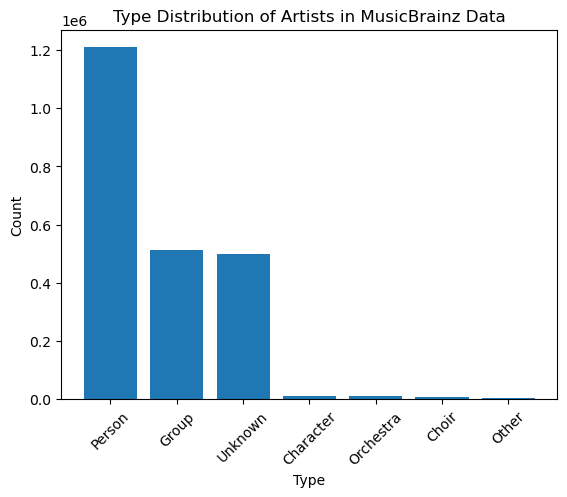

In [70]:
# plot artist type distribution
type_counts = brainz_conn.execute("SELECT type, COUNT(*) as count FROM mb_artist GROUP BY type ORDER BY count DESC").fetchdf()
type_counts['type'] = type_counts['type'].fillna('Unknown')

plt.bar(type_counts['type'], type_counts['count'])
plt.xlabel('Type')
plt.ylabel('Count')
plt.title('Type Distribution of Artists in MusicBrainz Data')
plt.xticks(rotation=45)
plt.show()

In [71]:
# number of records in mb_artist table of musicbrainz
brainz_conn.execute("SELECT COUNT(DISTINCT artist_id) AS distinct_count,COUNT(*) AS total_count FROM mb_artist").fetchall()

[(2251598, 2251598)]

# Explore MLHD+ Data

In [72]:
conn.execute(f"DESCRIBE SELECT * FROM read_parquet('{mlhd_path}')").fetchall()

[('user_id', 'UUID', 'YES', None, None, None),
 ('timestamp', 'BIGINT', 'YES', None, None, None),
 ('artist_ids', 'UUID[]', 'YES', None, None, None),
 ('release_id', 'UUID', 'YES', None, None, None),
 ('rec_id', 'UUID', 'YES', None, None, None)]

# Artist Gender

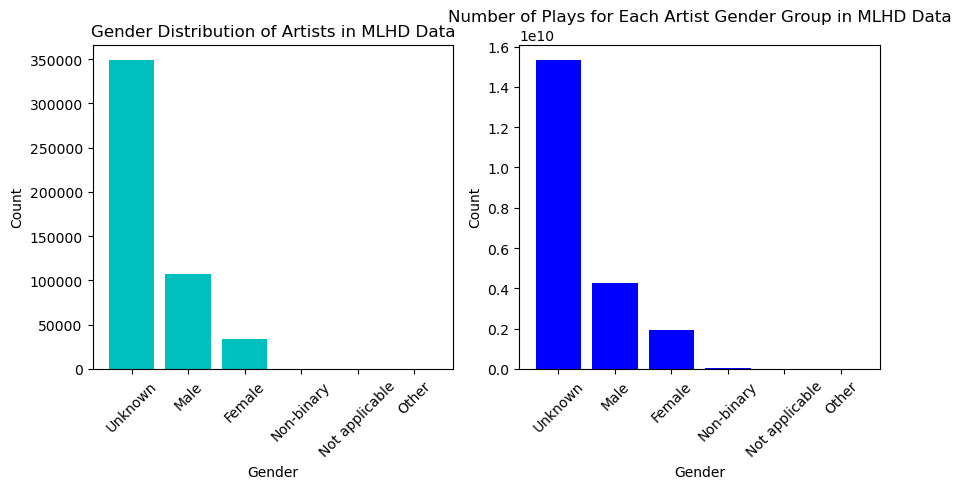

In [73]:
# plot gender distribution
query = f"SELECT * FROM read_parquet('{stat_path}/gender_count.parquet')"
gender_count = conn.execute(query).fetchdf()
gender_count['gender'] = gender_count['gender'].fillna('Unknown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))  

ax1.bar(gender_count['gender'], gender_count['unique_count'], color='c')  
ax1.set_title("Gender Distribution of Artists in MLHD Data")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(gender_count['gender'], gender_count['non_unique_count'], color='b') 
ax2.set_title("Number of Plays for Each Artist Gender Group in MLHD Data")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

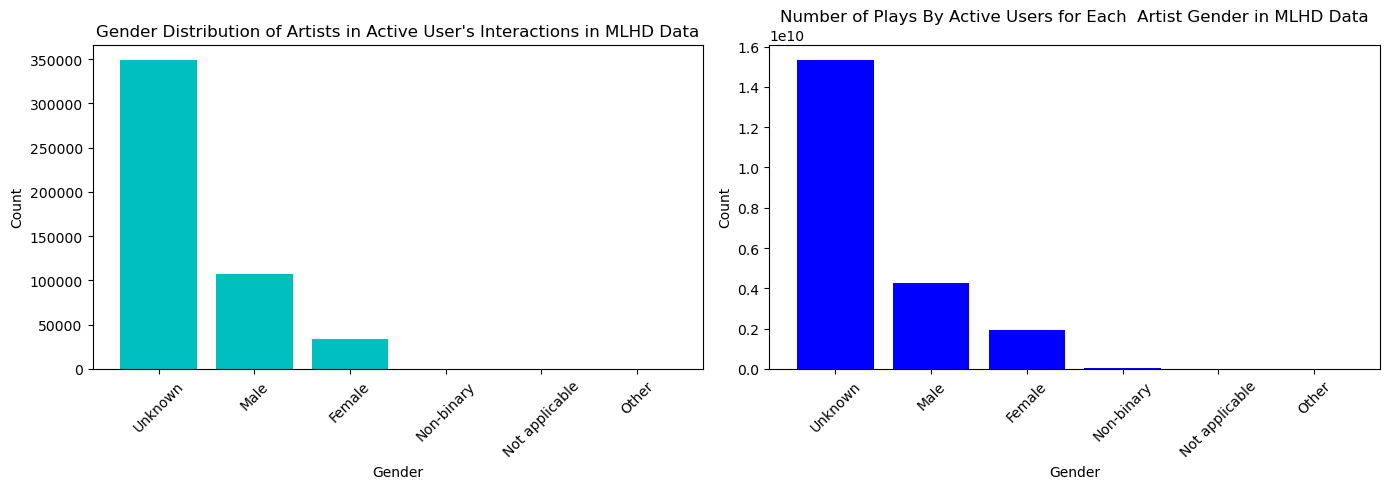

In [74]:
# plot gender distribution of artists in active users' data (with >=10 plays)
query = f"SELECT * FROM read_parquet('{stat_path}/gender_count_active.parquet')"
gender_count_active = conn.execute(query).fetchdf()
gender_count_active['gender'] = gender_count_active['gender'].fillna('Unknown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))  

ax1.bar(gender_count_active['gender'], gender_count_active['unique_count'], color='c')  
ax1.set_title("Gender Distribution of Artists in Active User's Interactions in MLHD Data")
ax1.set_xlabel("Gender")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(gender_count_active['gender'], gender_count_active['non_unique_count'], color='b') 
ax2.set_title("Number of Plays By Active Users for Each  Artist Gender in MLHD Data")
ax2.set_xlabel("Gender")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

# User and Play Stats by Release

In [75]:
# Gini Index of unique users and plays count for releases
query = f"SELECT * FROM read_parquet('{stat_path}/release_count.parquet')"
release_count = conn.execute(query).fetchdf()
print("Gini coefficient for n_users :", gini(release_count['n_users']))
print("Gini coefficient for n_plays:", gini(release_count['n_plays']))

Gini coefficient for n_users : 0.8811458734141489
Gini coefficient for n_plays: 0.9367042176392512


# Artist Type

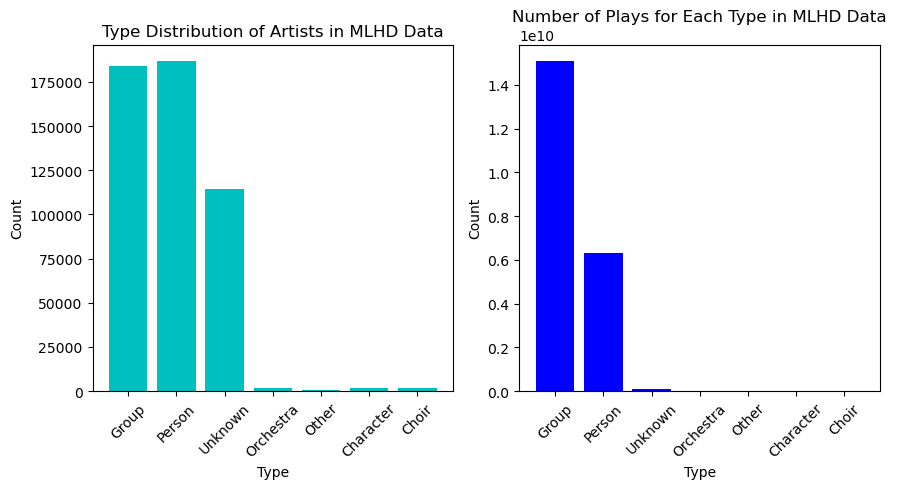

In [76]:
# plot type distribution
query = f"SELECT * FROM read_parquet('{stat_path}/type_count.parquet')"
type_count = conn.execute(query).fetchdf()
type_count['type'] = type_count['type'].fillna('Unknown')

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))  

ax1.bar(type_count['type'], type_count['unique_count'], color='c')  
ax1.set_title("Type Distribution of Artists in MLHD Data")
ax1.set_xlabel("Type")
ax1.set_ylabel("Count")
ax1.tick_params(axis='x', rotation=45)

ax2.bar(type_count['type'], type_count['non_unique_count'], color='b') 
ax2.set_title("Number of Plays for Each Type in MLHD Data")
ax2.set_xlabel("Type")
ax2.set_ylabel("Count")
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()  
plt.show()

# Music Genre

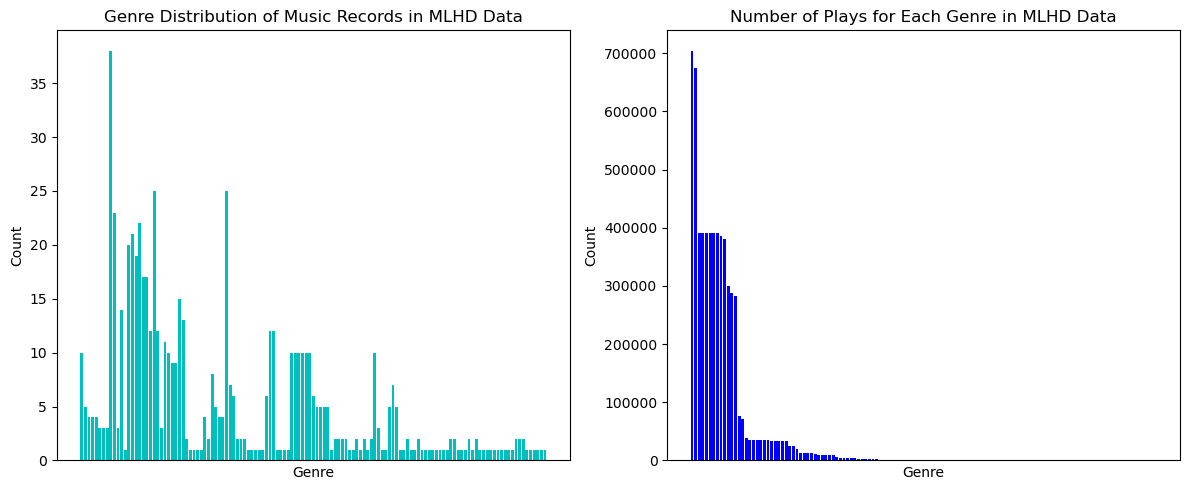

In [77]:
# plot genre distribution (unknown genre group is excluded from the plots)
query = f"SELECT * FROM read_parquet('{stat_path}/genre_count.parquet')"
genre_count = conn.execute(query).fetchdf()
genre_count = genre_count.dropna(subset=['genre_name'])

# sort data based on non_unique_count
# genre_count = genre_count.sort_values(by='unique_count', ascending=False) 

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  

ax1.bar(genre_count['genre_name'], genre_count['unique_count'], color='c')  
ax1.set_title("Genre Distribution of Music Records in MLHD Data")
ax1.set_xlabel("Genre")
ax1.set_ylabel("Count")
ax1.set_xticks([])

ax2.bar(genre_count['genre_name'], genre_count['non_unique_count'], color='b') 
ax2.set_title("Number of Plays for Each Genre in MLHD Data")
ax2.set_xlabel("Genre")
ax2.set_ylabel("Count")
ax2.set_xticks([])

plt.tight_layout()  
plt.show()

In [78]:
# top 5 common genres in MLHD data
top_unique_genres = genre_count.nlargest(5, 'unique_count')
print('The 5 Most Frequent Genres in MLHD:\n\n', top_unique_genres[['genre_name', 'unique_count']].to_string(index=False))

The 5 Most Frequent Genres in MLHD:

   genre_name  unique_count
      "rock"            38
       "edm"            25
       "pop"            25
 "hard rock"            23
"electronic"            22


In [79]:
# top 5 most-played genres in MLHD data
top_nunique_genres = genre_count.nlargest(5, 'non_unique_count')
print('The 5 Most Played Genres in MLHD:\n\n', top_nunique_genres[['genre_name', 'non_unique_count']].to_string(index=False))

The 5 Most Played Genres in MLHD:

         genre_name  non_unique_count
"alternative rock"            704277
      "indie rock"            673977
       "soft rock"            391637
     "baroque pop"            391031
 "psychedelic pop"            391031
